In [1]:
import numpy as np 
import pandas as pd
from sklearn import *
from sklearn.metrics import f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

sns.set_style("whitegrid")

from sklearn.model_selection import KFold

#Constants
ROW_PER_BATCH = 500000

from tensorflow import keras
from sklearn.metrics import f1_score, cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, train_test_split

/Users/christiant/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sub = pd.read_csv("sample_submission.csv", dtype=dict(time=str))

seq_len=1000

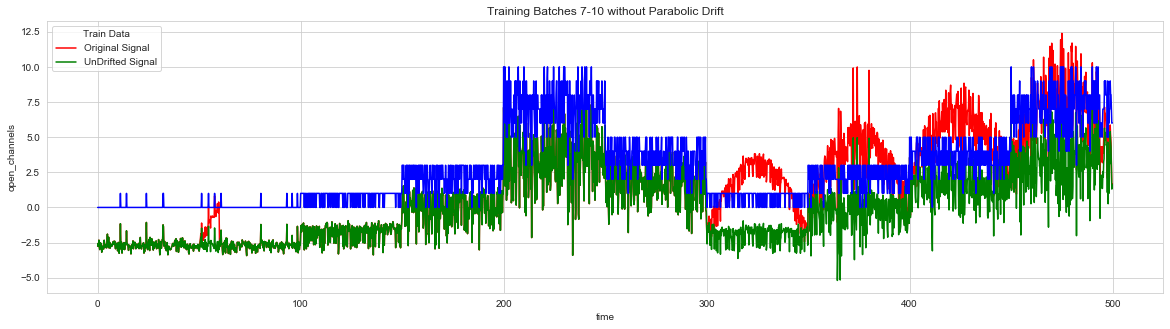

In [3]:
########################## clean train  ###################################
a=500000; b=600000
train['signal_undrifted'] = train.signal
train.loc[train.index[a:b],'signal_undrifted'] = train.signal[a:b].values - 3*(train.time.values[a:b] - 50)/10.


def f(x,low,high,mid): return -((-low+high)/625)*(x-mid)**2+high -low

batch = 7; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-1.817,3.186,325)
# CLEAN TRAIN BATCH 8
batch = 8; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,-0.094,4.936,375)
# CLEAN TRAIN BATCH 9
batch = 9; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,1.715,6.689,425)
# CLEAN TRAIN BATCH 10
batch = 10; a = 500000*(batch-1); b = 500000*batch
train.loc[train.index[a:b],'signal_undrifted'] = train.signal.values[a:b] - f(train.time[a:b].values,3.361,8.45,475)

plt.figure(figsize=(20,5))
sns.lineplot(train.time[::1000],train.signal[::2000],color='r').set_title('Training Batches 7-10 with Parabolic Drift')
#plt.figure(figsize=(20,5))
g = sns.lineplot(train.time[::1000],train.signal_undrifted[::2000],color='g').set_title('Training Batches 7-10 without Parabolic Drift')
plt.legend(title='Train Data',loc='upper left', labels=['Original Signal', 'UnDrifted Signal'])
sns.lineplot(train.time[::1000],train.open_channels[::2000],color='b')
plt.show(g)

In [4]:
############################### clean test  #################################
test['signal_undrifted'] = test.signal

# REMOVE BATCH 1 DRIFT
start=500
a = 0; b = 100000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=510
a = 100000; b = 200000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=540
a = 400000; b = 500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

start=560
a = 600000; b = 700000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=570
a = 700000; b = 800000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.
start=580
a = 800000; b = 900000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - 3*(test.time.values[a:b]-start)/10.

# REMOVE BATCH 3 DRIFT
def f(x):
    return -(0.00788)*(x-625)**2+2.345 +2.58
a = 1000000; b = 1500000
test.loc[test.index[a:b],'signal_undrifted'] = test.signal.values[a:b] - f(test.time[a:b].values)

In [6]:
X_test=test.signal_undrifted.values.reshape(-1, seq_len, 1)

X_undrifted=train.signal_undrifted.values.reshape(-1, seq_len, 1)
y=train.open_channels.values.reshape(-1, seq_len, 1)
X_train_undrifted, X_valid_undrifted, y_train, y_valid=train_test_split(X_undrifted, y, test_size=0.2, random_state=42)

In [7]:
class macroF1(keras.callbacks.Callback):
    def __init__(self, model, inputs, targets):
        self.model=model
        self.inputs=inputs
        self.targets=targets.reshape(-1)
    def on_epoch_end(self, epoch, logs):
        pred=np.argmax(self.model.predict(self.inputs), axis=-1).reshape(-1)
        
        f1_val=f1_score(self.targets, pred, average='macro'
                       )
        print ('val_f1_macro_score', f1_val)

In [9]:
model_biGRUall=keras.models.Sequential([
    keras.layers.Dense(256, input_shape=[seq_len, 1], activation='relu'),
    keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True, input_shape=[None, 1])),
    keras.layers.BatchNormalization(),
    keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.GRU(256, return_sequences=True, input_shape=[None, 1])),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model_biGRUall.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'] )

checkpoint_cb_biDRU= keras.callbacks.ModelCheckpoint("model_biGRU.h5", save_best_only=True)

In [10]:
history_biGRUall=model_biGRUall.fit(X_train_undrifted, y_train, epochs=30, batch_size=64, 
                          validation_data=(X_valid_undrifted, y_valid),
                          callbacks=[macroF1(model_biGRUall, X_valid_undrifted, y_valid), checkpoint_cb_biDRU], verbose=1)

Train on 4000 samples, validate on 1000 samples
Epoch 1/30
4000/4000 [==============================] - 667s 167ms/sample - loss: 0.5752 - accuracy: 0.8041 - val_loss: 1.6717 - val_accuracy: 0.3881
Epoch 2/30
4000/4000 [==============================] - 645s 161ms/sample - loss: 0.2095 - accuracy: 0.9239 - val_loss: 1.1749 - val_accuracy: 0.5925
Epoch 3/30
2944/4000 [=====================>........] - ETA: 2:38 - loss: 0.1735 - accuracy: 0.9346

KeyboardInterrupt: 